In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np

from pathlib import Path

metrics = Path("metrics/relax")

df = pd.DataFrame([])
for file in sorted(metrics.glob("*.json")):
    print(file.stem)
    df = pd.concat([df, pd.read_json(file)], axis=0)

df.shape

2023-05-12_2023-05-13
2023-05-13_2023-05-14
2023-05-14_2023-05-15
2023-05-15_2023-05-16
2023-05-16_2023-05-17
2023-05-17_2023-05-18
2023-05-18_2023-05-19
2023-05-19_2023-05-20
2023-05-20_2023-05-21
2023-05-21_2023-05-22
2023-05-22_2023-05-23
2023-05-23_2023-05-24
2023-05-24_2023-05-25


(1248, 6)

In [21]:
# circular block bootstrap
df['hour'] = df.index // 4
df['week'] = df.reset_index().index // (96 * 7) 
df['day'] = df.reset_index().index // 96

df = df.groupby(['week', 'day', 'hour']).mean().reset_index().drop(columns=['week', 'day'])
df
# df = df.drop(columns=['hour', 'week', 'day'])
# cbb_df = cbb_df.reset_index().drop(columns=['week', 'day'])
# cbb_df

,hour,kdpt_diffusion_anime,v4_anime_upscaler,v4_diffusion,v4_upscaler,v5_diffusion,v5_diffusion_anime
0,0,0.030675,0.031075,1.219525,7.246975,2.448850,5.734450
1,1,0.199700,0.195375,2.314600,3.017950,2.325075,4.206100
2,2,0.078150,0.067475,1.398950,3.305625,4.068850,8.889200
3,3,2.641150,3.196325,4.417900,2.851800,5.307425,12.023950
4,4,0.002075,0.002150,2.051775,8.005325,2.232525,4.854450
...,...,...,...,...,...,...,...
259,19,0.028500,0.039825,1.071100,8.569175,1.585950,2.694050
260,20,0.075450,0.113175,1.154350,7.156425,1.498300,5.032100
261,21,0.012450,0.010900,4.743000,0.123450,1.209500,3.762225
262,22,0.010050,0.019500,1.378100,1.317700,0.700475,3.084050


## Features for ML

In [22]:
# each index is 15 minutes of the day
time_seconds = df['hour'] * 60 * 60
time_seconds

0          0
1       3600
2       7200
3      10800
4      14400
       ...  
259    68400
260    72000
261    75600
262    79200
263    82800
Name: hour, Length: 264, dtype: int64

In [23]:
# clip
df = np.clip(df, 0, 15)
df[0:10]

,hour,kdpt_diffusion_anime,v4_anime_upscaler,v4_diffusion,v4_upscaler,v5_diffusion,v5_diffusion_anime
0,0,0.030675,0.031075,1.219525,7.246975,2.448850,5.734450
1,1,0.199700,0.195375,2.314600,3.017950,2.325075,4.206100
2,2,0.078150,0.067475,1.398950,3.305625,4.068850,8.889200
3,3,2.641150,3.196325,4.417900,2.851800,5.307425,12.023950
4,4,0.002075,0.002150,2.051775,8.005325,2.232525,4.854450
5,5,0.002700,0.003275,1.823450,6.121200,1.949350,1.698675
6,6,0.043900,0.083350,3.671850,1.778325,3.028375,3.213750
7,7,0.089775,0.160550,3.585325,2.525550,4.584925,5.572550
8,8,0.005325,0.010325,2.875175,4.077650,3.113925,6.680900
9,9,0.069175,0.086275,1.678650,9.874450,2.251175,5.665400


## Find Most Important Frequency

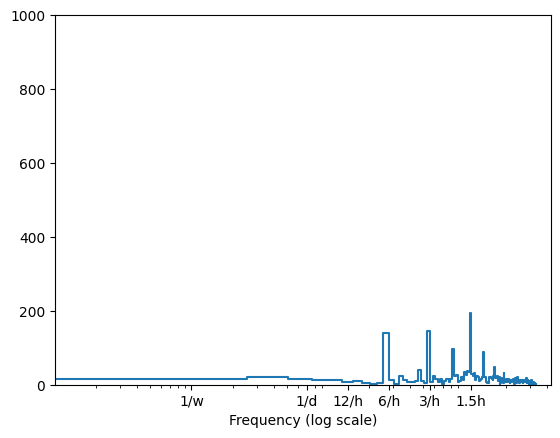

In [24]:
fft = tf.signal.rfft(df[df.columns[-1]])
f_per_dataset = np.arange(0, len(fft))

n_samples_15min = df.shape[0]
n_15min_per_week = 96 * 7
weeks_per_dataset = n_samples_15min/n_15min_per_week

f_per_week = f_per_dataset/weeks_per_dataset
plt.step(f_per_week, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 1000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 7, 7 * 2, 7 * 4, 7 * 8, 7 * 16], labels=['1/w', '1/d', '12/h', '6/h', '3/h', '1.5h'])
_ = plt.xlabel('Frequency (log scale)')

In [25]:
times = {
    # "1-hour": 1 * 60 * 60,
    # "3-hour": 3 * 60 * 60,
    "6-hour": 6 * 60 * 60,
    "12-hours": 12 * 60 * 60,
    "24-hours": 24 * 60 * 60,
    "1-week": 7 * 24 * 60 * 60,
}
for name, time in times.items():
    df[f"{name}_sin"] = np.sin(time_seconds * (2 * np.pi / time))
    df[f"{name}_cos"] = np.cos(time_seconds * (2 * np.pi / time))
df

,hour,kdpt_diffusion_anime,v4_anime_upscaler,v4_diffusion,v4_upscaler,v5_diffusion,v5_diffusion_anime,6-hour_sin,6-hour_cos,12-hours_sin,12-hours_cos,24-hours_sin,24-hours_cos,1-week_sin,1-week_cos
0,0,0.030675,0.031075,1.219525,7.246975,2.448850,5.734450,0.000000e+00,1.0,0.000000,1.000000e+00,0.000000,1.000000,0.000000,1.000000
1,1,0.199700,0.195375,2.314600,3.017950,2.325075,4.206100,8.660254e-01,0.5,0.500000,8.660254e-01,0.258819,0.965926,0.037391,0.999301
2,2,0.078150,0.067475,1.398950,3.305625,4.068850,8.889200,8.660254e-01,-0.5,0.866025,5.000000e-01,0.500000,0.866025,0.074730,0.997204
3,3,2.641150,3.196325,4.417900,2.851800,5.307425,12.023950,1.224647e-16,-1.0,1.000000,6.123234e-17,0.707107,0.707107,0.111964,0.993712
4,4,0.002075,0.002150,2.051775,8.005325,2.232525,4.854450,-8.660254e-01,-0.5,0.866025,-5.000000e-01,0.866025,0.500000,0.149042,0.988831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,15,0.028500,0.039825,1.071100,8.569175,1.585950,2.694050,8.660254e-01,0.5,-0.500000,-8.660254e-01,-0.965926,0.258819,0.652287,0.757972
260,15,0.075450,0.113175,1.154350,7.156425,1.498300,5.032100,8.660254e-01,-0.5,-0.866025,-5.000000e-01,-0.866025,0.500000,0.680173,0.733052
261,15,0.012450,0.010900,4.743000,0.123450,1.209500,3.762225,8.572528e-16,-1.0,-1.000000,-4.286264e-16,-0.707107,0.707107,0.707107,0.707107
262,15,0.010050,0.019500,1.378100,1.317700,0.700475,3.084050,-8.660254e-01,-0.5,-0.866025,5.000000e-01,-0.500000,0.866025,0.733052,0.680173


Text(0.5, 1.0, 'Time of "day" signal')

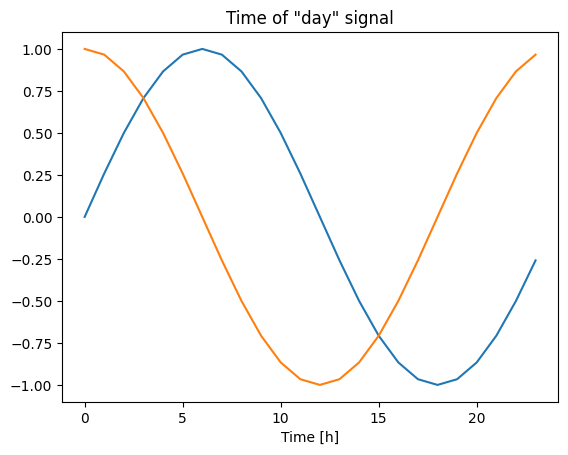

In [26]:
STEP = 24
plt.plot(np.array(np.sin(time_seconds * (2 * np.pi / (24*60*60))))[:STEP])
plt.plot(np.array(np.cos(time_seconds * (2 * np.pi / (24*60*60))))[:STEP])
plt.xlabel('Time [h]')
plt.title('Time of "day" signal')

## Split data

In [27]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]
# normalize
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std
print(train_df.shape, val_df.shape, test_df.shape)
train_df

(184, 15) (53, 15) (27, 15)


,hour,kdpt_diffusion_anime,v4_anime_upscaler,v4_diffusion,v4_upscaler,v5_diffusion,v5_diffusion_anime,6-hour_sin,6-hour_cos,12-hours_sin,12-hours_cos,24-hours_sin,24-hours_cos,1-week_sin,1-week_cos
0,-1.888347,-0.162175,-0.127368,-1.031258,1.122299,-0.153789,0.631105,-0.013314,1.406548,-0.018139,1.392460,-0.047344,1.420989,-1.706889,1.074798
1,-1.695316,0.521860,0.516109,-0.130760,-0.535204,-0.246961,-0.117218,1.211540,0.703274,0.687161,1.203476,0.320469,1.373229,-1.543989,1.068281
2,-1.502285,0.029953,0.015192,-0.883714,-0.422454,1.065666,2.175760,1.211540,-0.703274,1.203476,0.687161,0.663217,1.233204,-1.381316,1.048738
3,-1.309254,10.402281,12.269261,1.598817,-0.600324,1.998003,3.710623,-0.013314,-1.406548,1.392460,-0.018139,0.957540,1.010456,-1.219099,1.016197
4,-1.116223,-0.277918,-0.240652,-0.346886,1.419522,-0.316628,0.200232,-1.238168,-0.703274,1.203476,-0.723438,1.183383,0.720165,-1.057564,0.970703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,0.234994,-0.272556,-0.235659,-1.104115,-0.669981,-0.945325,-1.387534,-1.238168,0.703274,-0.723438,1.203476,0.320469,-1.334546,0.035302,0.297175
180,0.428025,5.896612,3.485680,-0.357350,-1.277460,-0.915196,-1.578967,-0.013314,1.406548,-0.018139,1.392460,-0.047344,-1.382306,0.183392,0.151847
181,0.621056,0.724814,-0.174855,0.359628,1.838393,0.830845,1.176882,1.211540,0.703274,0.687161,1.203476,-0.415157,-1.334546,0.328838,-0.005224
182,0.814087,-0.254749,-0.232819,3.111467,2.333916,0.350177,3.093495,1.211540,-0.703274,1.203476,0.687161,-0.757904,-1.194521,0.471437,-0.173819


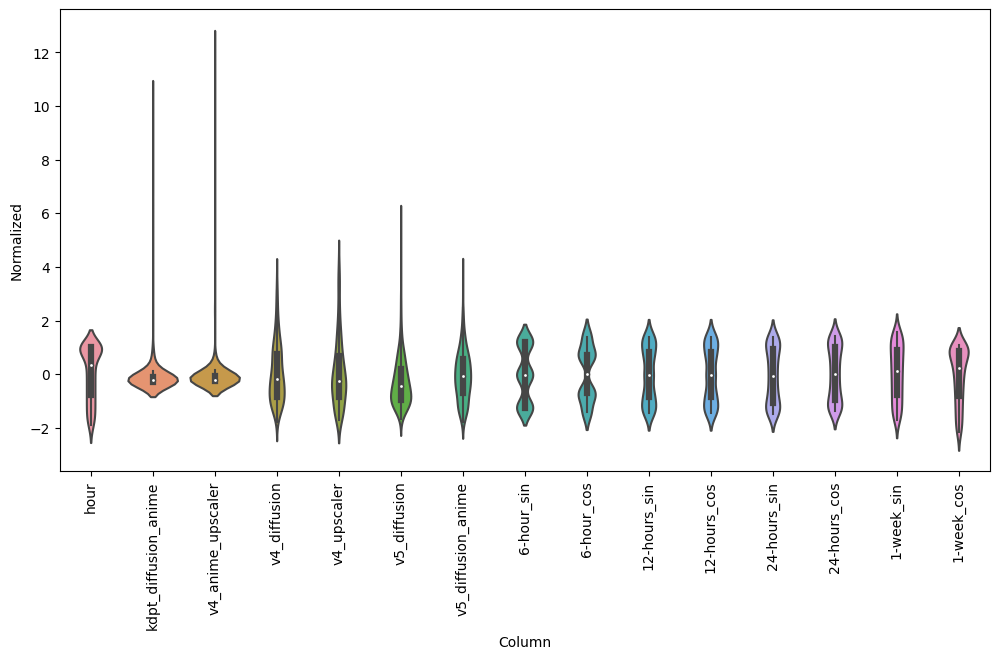

In [28]:
import seaborn as sns
# plot dist
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Data Windowing

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data. 

The main features of the input windows are:

- The width (number of time steps) of the input and label windows.
- The time offset between them.
- Which features are used as inputs, labels, or both. 

In [29]:
from app.window import WindowGenerator
from app.compile import compile_and_fit

## Multi-step models

Both the single-output and multiple-output models in the previous sections made **single time step predictions**, one hour into the future.

This section looks at how to expand these models to make **multiple time step predictions**.

In a multi-step prediction, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predicts a sequence of the future values.

There are two rough approaches to this:

1. Single shot predictions where the entire time series is predicted at once.
2. Autoregressive predictions where the model only makes single step predictions and its output is fed back as its input.

In this section all the models will predict **all the features across all output time steps**.


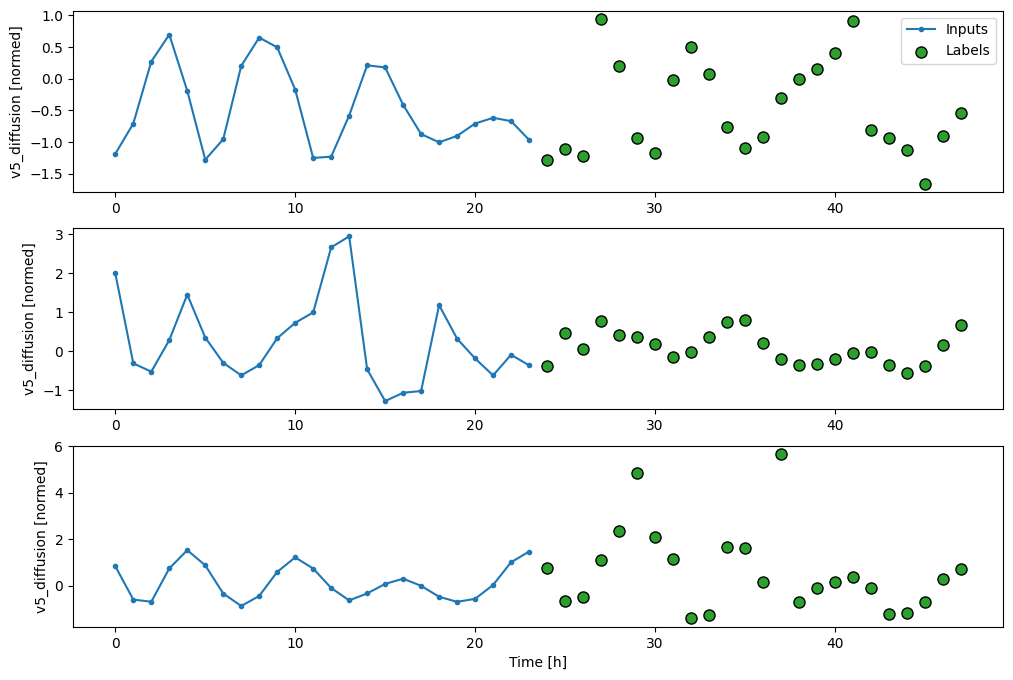

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

In [30]:
OUT_STEPS = 24
multi_window = WindowGenerator(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    input_width=24,
    label_width=OUT_STEPS,
    shift=OUT_STEPS,
)
multi_window.plot(plot_col=df.columns[5])
multi_window

## Multistep baseline

Since this task is to predict 24 hours into the future, given 24 hours of the past, another simple approach is to repeat the previous day, assuming tomorrow will be similar:


1/1 [==============================] - 0s 171ms/step - loss: 0.8819 - mean_absolute_error: 0.3176


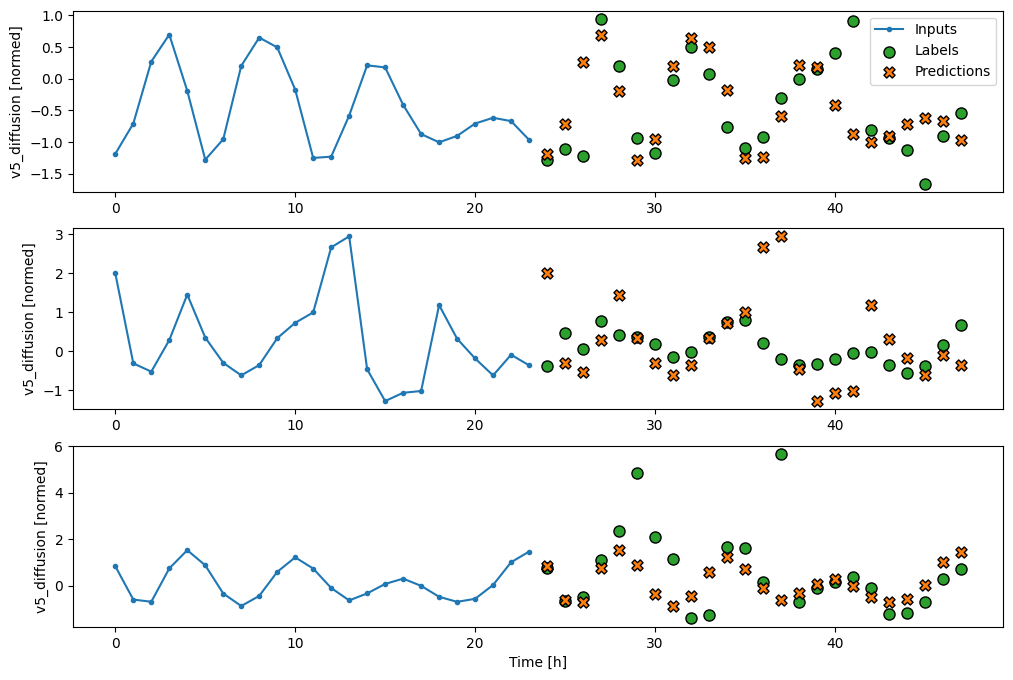

In [31]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(model=repeat_baseline, plot_col=df.columns[5])

### Single-shot models

One high-level approach to this problem is to use a "single-shot" model, where the model makes the entire sequence prediction in a single step.

This can be implemented efficiently as a `tf.keras.layers.Dense` with `OUT_STEPS*features` output units. The model just needs to reshape that output to the required `(OUTPUT_STEPS, features)`.

#### Linear

A simple linear model based on the last input time step does better than either baseline, but is underpowered. The model needs to predict `OUTPUT_STEPS` time steps, from a single input time step with a linear projection. It can only capture a low-dimensional slice of the behavior, likely based mainly on the time of day and time of year.

1/1 [==============================] - 0s 53ms/step - loss: 0.8571 - mean_absolute_error: 0.7214


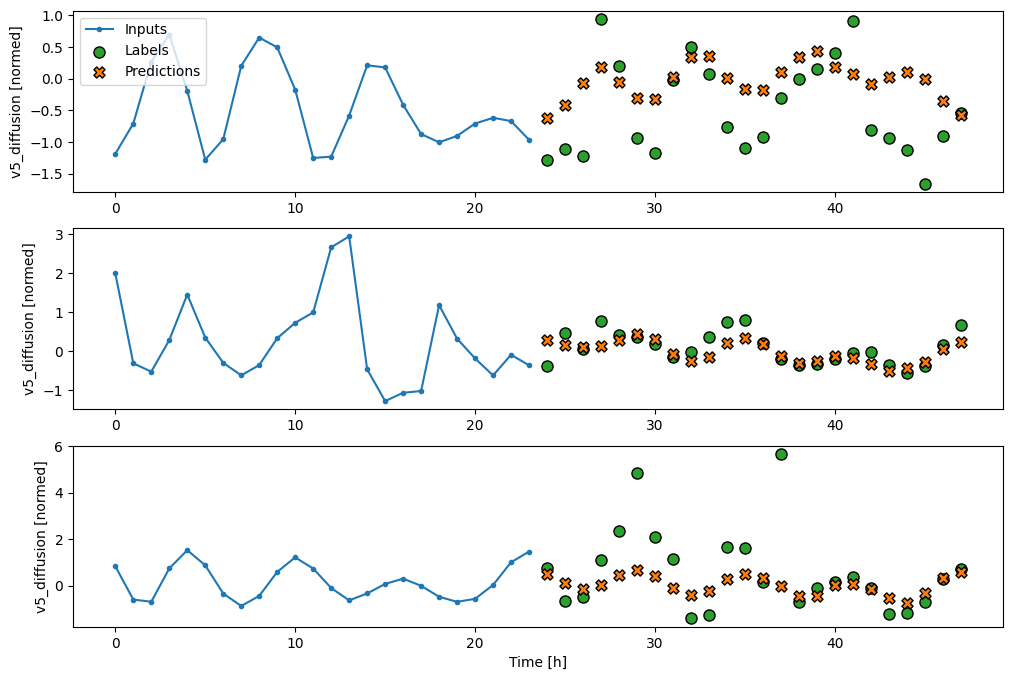

In [32]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(model=multi_linear_model, plot_col=df.columns[5])

### Dense

1/1 [==============================] - 0s 51ms/step - loss: 0.4174 - mean_absolute_error: 0.3327


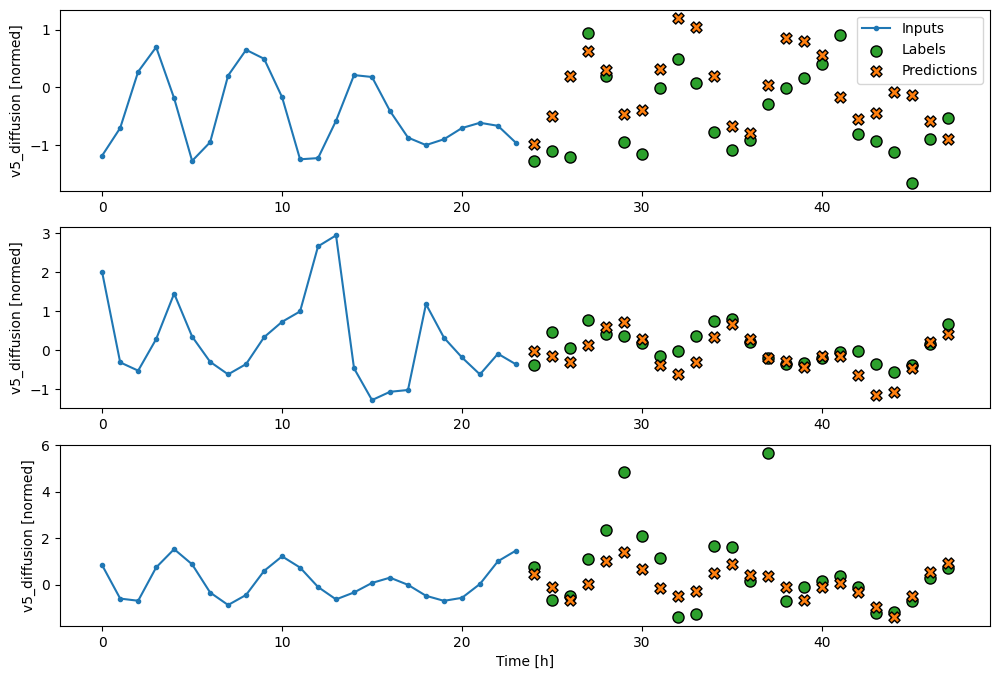

In [33]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(model=multi_dense_model, plot_col=df.columns[5])


### CNN

1/1 [==============================] - 0s 52ms/step - loss: 0.3418 - mean_absolute_error: 0.3391


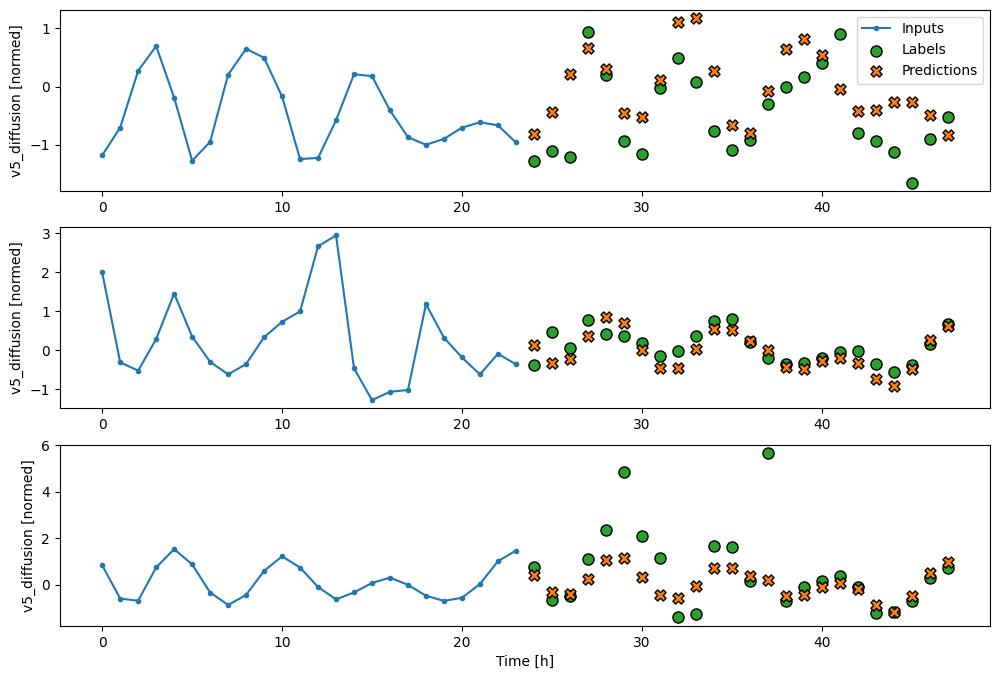

In [34]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(model=multi_conv_model, plot_col=df.columns[5])

### LSTM

1/1 [==============================] - 0s 78ms/step - loss: 0.7901 - mean_absolute_error: 0.6135


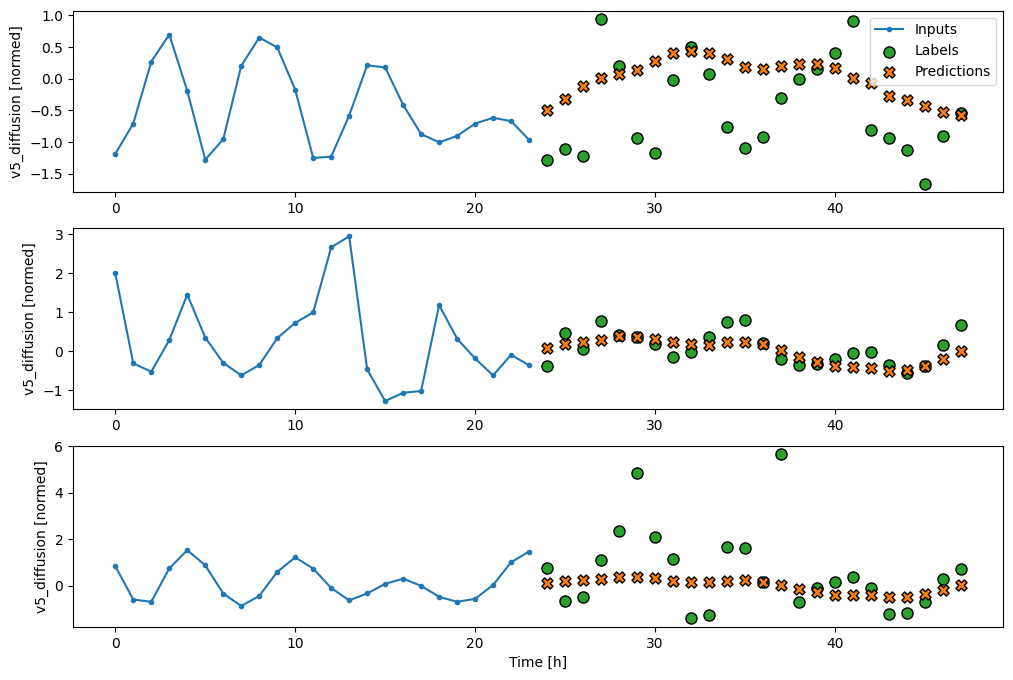

In [35]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(model=multi_lstm_model, plot_col=df.columns[5])

### Multi Performance

In [36]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()
multi_val_performance, multi_performance

IndexError: list index out of range